<a href="https://colab.research.google.com/github/Quingu/MachineLearning_For_ASD-AutisticSpectrumDisorder-_And_TD-TypicallyDeveloping-/blob/main/ASD(AutisticSpectrumDisorder)_TD(TypicallyDeveloping).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Composição do Dataset**

O dataset consiste em **61 amostras** e **5619 features**.
* **Amostras:** As amostras são divididas em dois grupos: 30 de crianças com desenvolvimento típico (TD - Controle) e 30 de crianças com Transtorno do Espectro Autista (ASD - Caso).
* **Features:** As 5618 colunas de features (após remover a coluna de ID) representam diferentes táxons de microbiota (como bactérias, arquéias, etc.) identificados nas amostras.


# **Reflexão sobre as Categorias de Abundância:**

Os valores no dataset foram "discretizados", ou seja, convertidos de valores numéricos contínuos para categorias. As categorias encontradas são: `['absent' 'present' 'low' 'mid' 'high']`.

* **`absent` / `present`**: Esta é uma representação binária que simplesmente indica a presença ou ausência de um microrganismo. É útil, mas ignora completamente a quantidade.
* **`low` / `mid` / `high`**: Estas categorias fornecem um nível ordinal de abundância. Isso simplifica os dados e pode ajudar a reduzir o ruído de medições muito precisas. No entanto, a principal desvantagem é a perda de informação. A diferença entre "low" e "mid" pode não ser a mesma que entre "mid" e "high". Além disso, a definição desses limiares é subjetiva e pode impactar fortemente o desempenho do modelo.


# **Importações:**

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_auc_score, classification_report, RocCurveDisplay
import numpy as np

# **Carregamento dos dados**

In [ ]:
# Dataset original
data = pd.read_csv("sample_data/ASD_meta_abundance_discretized.csv")

# Remover a primeira coluna de identificadores
df = data.drop(columns=["Unnamed: 0"])

#Criar target binário fictício (30 controles, 30 casos)
y = np.array([0]*30 + [1]*30)

# One-Hot Encoding (cada categoria vira coluna binária)
X = pd.get_dummies(df)



# **Divisão de Treino e Teste**

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# **Definir pipeline com SelectKBest e SVC**

In [ ]:
pipeline = Pipeline([
    ('select', SelectKBest(score_func=chi2, k=500)),
    ('clf', SVC(probability=True))
])

# **Parâmetros para GridSearchCV**

In [ ]:
param_grid = {
    'clf__C': [0.1, 1, 10, 100],
    'clf__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
    'clf__gamma': ['scale', 'auto']
}

# **GridSearchCV**

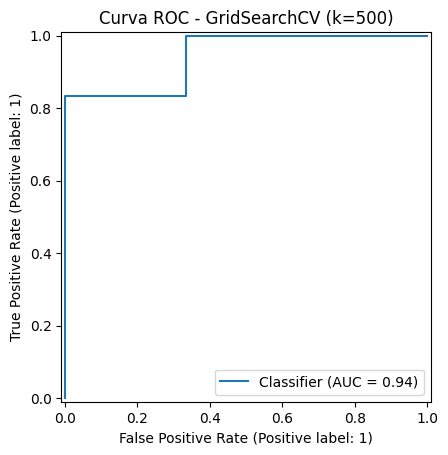

Resultados do GridSearchCV:


{'best_params': {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'},
 'accuracy': 0.8333333333333334,
 'sensibilidade': 1.0,
 'especificidade': np.float64(0.6666666666666666),
 'roc_auc': np.float64(0.9444444444444445)}

In [ ]:
grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1)
grid.fit(X_train, y_train)

# Previsões
y_pred = grid.predict(X_test)
y_proba = grid.predict_proba(X_test)[:, 1]


# Métricas
acc = accuracy_score(y_test, y_pred)
sens = recall_score(y_test, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
spec = tn / (tn + fp)
roc_auc = roc_auc_score(y_test, y_proba)

# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba)
plt.title("Curva ROC - GridSearchCV (k=500)")
plt.show()

grid_results = {
    "best_params": grid.best_params_,
    "accuracy": acc,
    "sensibilidade": sens,
    "especificidade": spec,
    "roc_auc": roc_auc
}

print("Resultados do GridSearchCV:")
grid_results

# **RandomizedSearchCV**

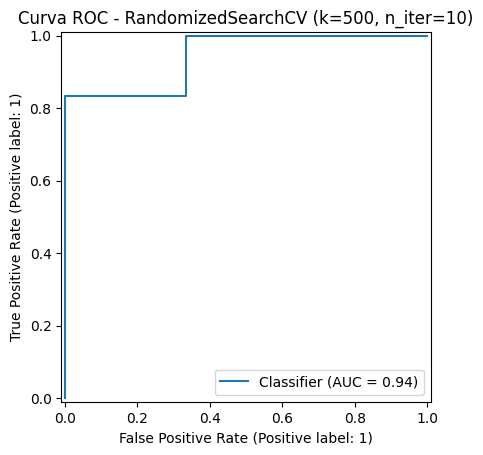

Resultados do RandomizedSearchCV:


{'best_params': {'clf__kernel': 'rbf', 'clf__gamma': 'scale', 'clf__C': 100},
 'accuracy': 0.8333333333333334,
 'sensibilidade': 1.0,
 'especificidade': np.float64(0.6666666666666666),
 'roc_auc': np.float64(0.9444444444444445)}

In [ ]:
random_search = RandomizedSearchCV(pipeline, param_distributions=param_grid, n_iter=10, cv=3, scoring='accuracy', n_jobs=-1)

random_search.fit(X_train, y_train)

# Previsões
y_pred_random = random_search.predict(X_test)
y_proba_random = random_search.predict_proba(X_test)[:, 1]

# Métricas
acc_random = accuracy_score(y_test, y_pred_random)
sens_random = recall_score(y_test, y_pred_random)
tn_random, fp_random, fn_random, tp_random = confusion_matrix(y_test, y_pred_random).ravel()
spec_random = tn_random / (tn_random + fp_random)
roc_auc_random = roc_auc_score(y_test, y_proba_random)

# Curva ROC
RocCurveDisplay.from_predictions(y_test, y_proba_random)
plt.title("Curva ROC - RandomizedSearchCV (k=500, n_iter=10)")
plt.show()

random_results = {
    "best_params": random_search.best_params_,
    "accuracy": acc_random,
    "sensibilidade": sens_random,
    "especificidade": spec_random,
    "roc_auc": roc_auc_random
}

print("Resultados do RandomizedSearchCV:")
random_results

# **Análise Crítica: GridSearchCV vs. RandomizedSearchCV**

### GridSearchCV
* **Vantagem:** Garante que a melhor combinação de parâmetros dentro do grid especificado será encontrada. É metódico e exaustivo.
* **Limitação:** Sofre de "maldição da dimensionalidade". Se tivermos muitos parâmetros ou muitos valores para testar, o número de combinações cresce exponencialmente, tornando-o computacionalmente inviável.

### RandomizedSearchCV
* **Vantagem:** Muito mais eficiente. Frequentemente, encontra um modelo "bom o suficiente" (ou até melhor) em uma fração do tempo. Permite uma exploração mais ampla do espaço de parâmetros.
* **Limitação:** Não garante encontrar o melhor modelo. O desempenho depende da aleatoriedade e do número de iterações (`n_iter`).

# **RESPOSTA:**

**Sim**, é possível identificar padrões discriminativos na microbiota intestinal de crianças com `ASD vs TD` usando aprendizado de máquina.




